In [17]:
import os
import zipfile
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import subprocess
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [18]:
os.makedirs("dataset", exist_ok=True)

# Ekstrak isi zip ke folder "dataset"
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Ekstrak selesai!")

Ekstrak selesai!


In [19]:
for root, dirs, files in os.walk("dataset"):
    level = root.replace("dataset", "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files[:5]:  # tampilkan maksimal 5 file pertama per folder
        print(f"{subindent}{f}")

dataset/
  data/
    non-vehicles/
      extra1.png
      extra10.png
      extra100.png
      extra1000.png
      extra1001.png
    vehicles/
      1.png
      10.png
      1000.png
      1001.png
      1002.png


In [20]:
base_dir = "split_dataset"
classes = ['vehicles', 'non-vehicles']
splits = ['train', 'val', 'test']
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

In [21]:
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)
def split_and_copy(src_dir, cls):
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)
    total = len(files)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_files = {
        'train': files[:train_end],
        'val': files[train_end:val_end],
        'test': files[val_end:]
    }

    for split, split_file_list in split_files.items():
        for f in split_file_list:
            shutil.copy2(os.path.join(src_dir, f), os.path.join(base_dir, split, cls, f))

for cls in classes:
    src = os.path.join("dataset/data", cls)
    split_and_copy(src, cls)

In [22]:
img_size = (150, 150)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [23]:
train_data = train_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 17705 images belonging to 2 classes.
Found 9889 images belonging to 2 classes.
Found 9872 images belonging to 2 classes.


In [24]:
model = Sequential([
    Input(shape=(150, 150, 3)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [26]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
554/554 [==============================] - 337s 606ms/step - loss: 0.1241 - accuracy: 0.9528 - val_loss: 0.0601 - val_accuracy: 0.9810
Epoch 2/5
554/554 [==============================] - 211s 380ms/step - loss: 0.0537 - accuracy: 0.9822 - val_loss: 0.0725 - val_accuracy: 0.9747
Epoch 3/5
554/554 [==============================] - 217s 391ms/step - loss: 0.0553 - accuracy: 0.9810 - val_loss: 0.0141 - val_accuracy: 0.9958
Epoch 4/5
554/554 [==============================] - 215s 388ms/step - loss: 0.0237 - accuracy: 0.9914 - val_loss: 0.0130 - val_accuracy: 0.9950
Epoch 5/5
554/554 [==============================] - 210s 380ms/step - loss: 0.0384 - accuracy: 0.9881 - val_loss: 0.0127 - val_accuracy: 0.9958


In [27]:
loss, accuracy = model.evaluate(val_data)
print(f"Loss Validasi: {loss}")
print(f"Akurasi Validasi: {accuracy}")


310/310 [==============================] - 20s 65ms/step - loss: 0.0127 - accuracy: 0.9958
Loss Validasi: 0.012682925909757614
Akurasi Validasi: 0.9957528710365295


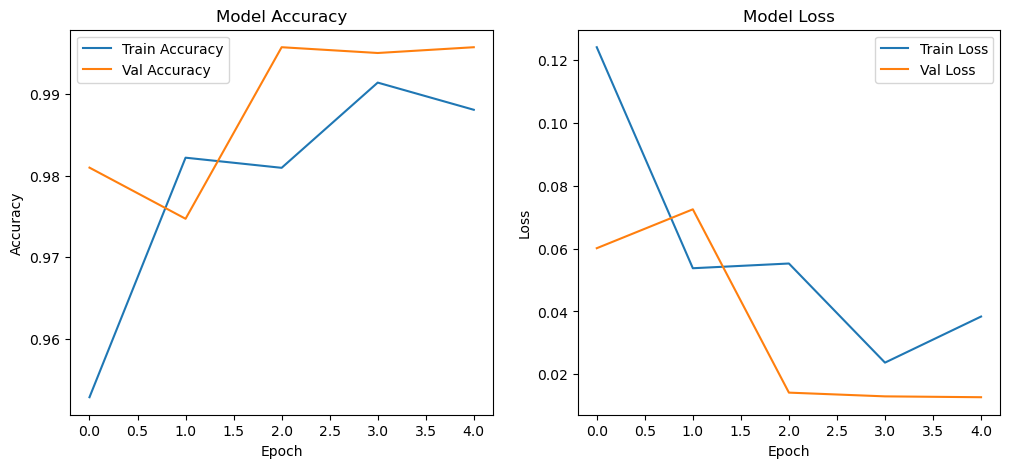

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [29]:
os.makedirs("saved_model", exist_ok=True)
model.save("saved_model/vehicle_classifier.keras")

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("vehicle_classifier.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\IQBAL\AppData\Local\Temp\tmpw5u__l3d\assets


INFO:tensorflow:Assets written to: C:\Users\IQBAL\AppData\Local\Temp\tmpw5u__l3d\assets


In [31]:
subprocess.run([
    "tensorflowjs_converter",
    "--input_format=keras",
    "saved_model/vehicle_classifier.keras",
    "tfjs_model/"
])


CompletedProcess(args=['tensorflowjs_converter', '--input_format=keras', 'saved_model/vehicle_classifier.keras', 'tfjs_model/'], returncode=1)